###### 1. Import Libraries/ Dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras

print(tf.__version__)

2.4.1


In [ ]:
# copy dataset
!wget --no-check-certificate \
  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz \
  -O /tmp/imagenette2-160.tgz

--2021-05-10 09:46:51--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘/tmp/imagenette2-160.tgz’

/tmp/imagenette2-16 100%[===================>]  94.42M  54.0MB/s    in 1.7s    

2021-05-10 09:46:53 (54.0 MB/s) - ‘/tmp/imagenette2-160.tgz’ saved [99003388/99003388]



In [ ]:
import os
import tarfile

# open file
file = tarfile.open('/tmp/imagenette2-160.tgz')
  
# extract file
file.extractall('/tmp')

#close file
file.close()

In [ ]:
# set directories
base_dir = '/tmp/imagenette2-160'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

###### 2. Data Visualization and Augmentation

In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# set image and batch size
num_img_rows=75 # image height, actual=213
num_img_cols=75 # image width, actual=160
num_color_channels=3
num_batch_size=100

train_datagen = ImageDataGenerator(
                  rescale=1.0/255.0,
                  rotation_range=40,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                )

val_datagen = ImageDataGenerator(
                rescale=1.0/255.0
              )

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=num_batch_size,
                    target_size=(num_img_rows, num_img_cols),
                    class_mode='categorical'
                  )

val_generator = val_datagen.flow_from_directory(
                  val_dir,
                  batch_size=num_batch_size,
                  target_size=(num_img_rows, num_img_cols),
                  class_mode='categorical'
                )

# print shape of training data after transformation
for train_image_batch, train_labels_batch in train_generator:
  print('Training image batch shape, after transformation:', train_image_batch.shape)
  print('Training label batch shape, after transformation:', train_labels_batch.shape)
  break

# print shape of test data after transformation
for val_image_batch, val_labels_batch in val_generator:
  print('Validation image batch shape, after transformation:', val_image_batch.shape)
  print('Validation label batch shape, after transformation:', val_labels_batch.shape)
  break

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Training image batch shape, after transformation: (100, 75, 75, 3)
Training label batch shape, after transformation: (100, 10)
Validation image batch shape, after transformation: (100, 75, 75, 3)
Validation label batch shape, after transformation: (100, 10)


###### 3. Model Building

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

# set model parameters
num_epochs=50
num_steps_per_epoch=95 # total training images/ batch size = 9465/100
num_val_steps=40 # total validation images/ batch size = 3925/100
num_dropout=0.2
num_l2_reg_penalty=0.0001
num_lr=1e-4

# build model
model = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer with regularization
          tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = hidden layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 3 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 4 = hidden layer with regularization
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 5 = output layer with regularization
          tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
        ])

###### 4. Model Compilation

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer=RMSprop(lr=num_lr),
              metrics=['accuracy']
             )

###### 5. Model Training

In [ ]:
# train model
history = model.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1
          )

# show model summary
model.summary()

# save model
#model.save("vision.h5")

Epoch 1/50
190/190 [==============================] - 25s 118ms/step - loss: 2.6486 - accuracy: 0.1559 - val_loss: 2.3573 - val_accuracy: 0.2306
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16875)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              17281024  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)   

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

NameError: ignored

###### 6. Model Evaluation

In [ ]:
# final training accuracy and loss
train_score = model.evaluate(train_generator)

print("Training accuracy: {:.2f}%".format(train_score[1] * 100)) 
print("Training Loss: ",train_score[0])

# final validation accuracy and loss
val_score = model.evaluate(val_generator)

print("Validation accuracy: {:.2f}%".format(val_score[1] * 100)) 
print("Validation Loss: ",val_score[0])

95/95 [==============================] - 35s 363ms/step - loss: 1.7266 - accuracy: 0.4212
Training accuracy: 42.12%
Training Loss:  1.7265675067901611
40/40 [==============================] - 5s 112ms/step - loss: 1.7693 - accuracy: 0.4148
Validation accuracy: 41.48%
Validation Loss:  1.769339680671692


Target names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

   n01440764       0.09      0.13      0.11       963
   n02102040       0.10      0.09      0.10       955
   n02979186       0.11      0.07      0.08       993
   n03000684       0.11      0.05      0.06       858
   n03028079       0.10      0.15      0.12       941
   n03394916       0.09      0.15      0.11       956
   n03417042       0.10      0.08      0.09       961
   n03425413       0.10      0.13      0.11       931
   n03445777       0.11      0.08      0.09       951
   n03888257       0.11      0.10      0.10       960

    accuracy                           0.10      9469
   macro avg       0.10      0.10      0.10      9469
weighted avg       0.10      0.10      0.10      9469



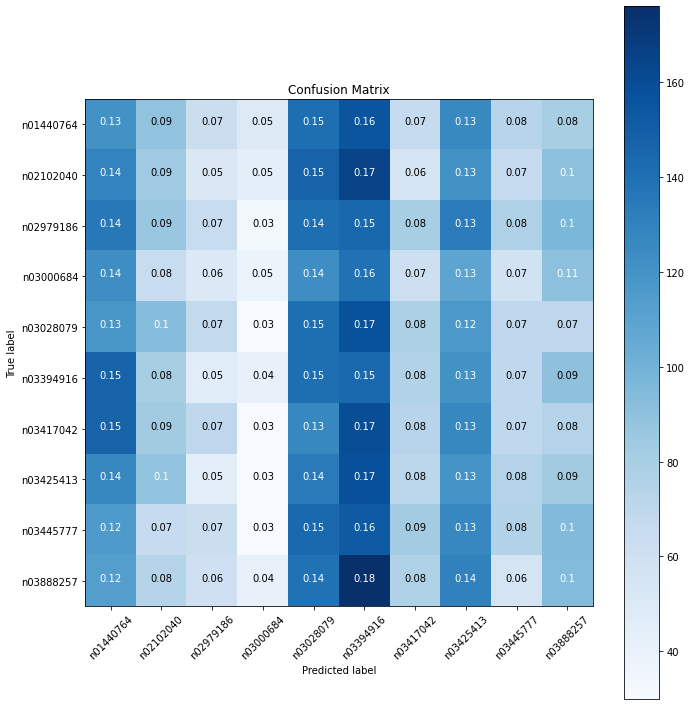

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# get target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print target_names
print('Target names:', target_names)

# Plot Confution Matrix helper function
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Print Confusion Matrix 
Y_pred = model.predict(train_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(train_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Print Classification Report
print('Classification Report')
print(classification_report(train_generator.classes, y_pred, target_names=target_names))